In [1]:
from pcapreader import PcapReader
import numpy as np 
import struct


c:\Users\111\.conda\envs\mm_p\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\111\.conda\envs\mm_p\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\111\.conda\envs\mm_p\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [16]:
# STATIC
MAX_PACKET_SIZE = 4096
BYTES_IN_PACKET = 1456
BYTES_IN_HEADER = 10
ADC_PARAMS = {'chirps': 8,  # 32
              'rx': 4,
              'tx': 3,
              'samples': 256,
              'IQ': 2,
              'bytes': 2}

# DYNAMIC
BYTES_IN_FRAME = (ADC_PARAMS['chirps'] * ADC_PARAMS['rx'] * ADC_PARAMS['tx'] *
                  ADC_PARAMS['IQ'] * ADC_PARAMS['samples'] * ADC_PARAMS['bytes'])
BYTES_IN_FRAME_CLIPPED = (BYTES_IN_FRAME // BYTES_IN_PACKET) * BYTES_IN_PACKET
PACKETS_IN_FRAME = BYTES_IN_FRAME / BYTES_IN_PACKET
PACKETS_IN_FRAME_CLIPPED = BYTES_IN_FRAME // BYTES_IN_PACKET
UINT16_IN_PACKET = BYTES_IN_PACKET // 2
UINT16_IN_FRAME = BYTES_IN_FRAME // 2


In [17]:
6//2

3

In [18]:
print(BYTES_IN_FRAME, BYTES_IN_FRAME_CLIPPED)

98304 97552


In [19]:
def format_frames(data_packets):
    frames = []

    # Frame buffer
    packet_ctr = 0
    debug_cnt = 0
    MAX_PACKET_COUNT = len(data_packets)
    while(packet_ctr != MAX_PACKET_COUNT):
        print(packet_ctr)
        ret_frame = np.zeros(UINT16_IN_FRAME, dtype=np.uint16)

        # Wait for start of next frame
        while True:
            packet_num, byte_count, packet_data = data_packets[packet_ctr]
            packet_ctr +=1
            if byte_count % BYTES_IN_FRAME_CLIPPED == 0:
                packets_read = 1
                ret_frame[0:UINT16_IN_PACKET] = packet_data = packet_data
                break
            # if(packet_ctr >=MAX_PACKET_COUNT):
            #     break

        if(packet_ctr >=MAX_PACKET_COUNT):
                break
        # Read in the rest of the frame            
        while True:
            packet_num, byte_count, packet_data = data_packets[packet_ctr]
            packet_ctr+=1
            if(packet_ctr >=MAX_PACKET_COUNT):
                break
            packets_read += 1

            if byte_count % BYTES_IN_FRAME_CLIPPED == 0:
                print(f"Num packets lost = {PACKETS_IN_FRAME_CLIPPED - packets_read}")
                frames.append(ret_frame)
                break

            curr_idx = ((packet_num - 1) % PACKETS_IN_FRAME_CLIPPED)
            try:
                ret_frame[curr_idx * UINT16_IN_PACKET:(curr_idx + 1) * UINT16_IN_PACKET] = packet_data
            except:
                pass

            if packets_read > PACKETS_IN_FRAME_CLIPPED:
                packets_read = 0
        
        if(packet_ctr >=MAX_PACKET_COUNT):
                break
    
    return frames

In [20]:
def organize(raw_frame, num_chirps, num_rx, num_samples):
        """Reorganizes raw ADC data into a full frame

        Args:
            raw_frame (ndarray): Data to format
            num_chirps: Number of chirps included in the frame
            num_rx: Number of receivers used in the frame
            num_samples: Number of ADC samples included in each chirp

        Returns:
            ndarray: Reformatted frame of raw data of shape (num_chirps, num_rx, num_samples)

        """
        ret = np.zeros(len(raw_frame) // 2, dtype=complex)

        # Separate IQ data
        ret[0::2] = raw_frame[0::4] + 1j * raw_frame[2::4]
        ret[1::2] = raw_frame[1::4] + 1j * raw_frame[3::4]
        return ret.reshape((num_chirps, num_rx, num_samples))

In [21]:
def organize_all(data, params):
    assert len(params) == 3
    
    organized_data = []
    for i in range(len(data)):
        organized_data.append(organize(data[i], *params))

    return organized_data

In [31]:
data_packets = []
packet_numbers = []
byte_counts = []
packet_arrivals = []

reader = PcapReader("D:\syndicate_tests_sv_radar_test_4rx_3tx\FMCW_Radar\FMCW_Radar.raw")
next_packet = reader.pnext()
count = 1
prev_time = 0
while next_packet[0] is not None:
    curr_time = next_packet[0][0]
    data_=next_packet[1]
    data = data_[42:]
    if(len(data) == BYTES_IN_HEADER + BYTES_IN_PACKET):
        packet_num = struct.unpack('<1l', data[:4])[0]
        packet_numbers.append(packet_num)

        byte_count = struct.unpack('>Q', b'\x00\x00' + data[4:10][::-1])[0]
        byte_counts.append(byte_count)

        data = data[10:]
        data_packets.append(np.frombuffer(data, dtype=np.uint16))
    else:
        print(len(data))

    next_packet = reader.pnext()
    count+=1

print("Count:", count)
print("True Packet Count:", len(data_packets))

all_data = list(zip(packet_numbers, byte_counts, data_packets))


8
8
8
8
8
Count: 48
True Packet Count: 42


In [32]:
frames = format_frames(all_data)

0


In [33]:
len(frames)

0

: 

In [26]:
len(frames)/100

2.52

In [27]:
frames[0].shape

(49152,)

In [30]:
256*4*3*8

24576

In [28]:
import matplotlib.pyplot as plt 

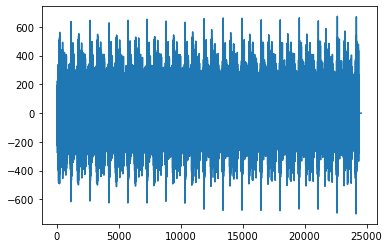

In [29]:
idx = 1
plt.plot(frames[idx][::2].astype(np.int16))

In [15]:
organized_packets = organize_all(frames, params=(3,4,512))

ValueError: cannot reshape array of size 3072 into shape (3,4,512)

In [142]:
print(len(organized_packets), organized_packets[0].shape)

316 (3, 4, 512)


In [143]:
316*3*4

3792

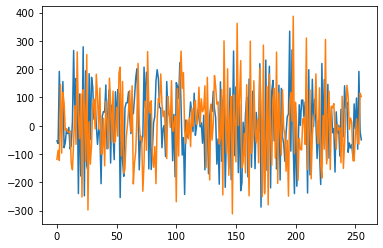

In [140]:
plt.plot(np.real(organized_packets[-1][0,0][::2]).astype(np.int16))
plt.plot(np.imag(organized_packets[-1][0,0][::2]).astype(np.int16))

c:\Users\111\.conda\envs\mm_p\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


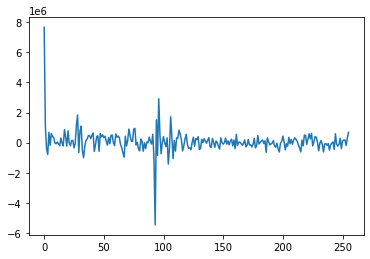

In [141]:
plt.plot(np.fft.fft(organized_packets[0][0,0][::2]))

In [ ]:
reader = PcapReader("D:\syndicate_tests\FMCW_Radar\FMCW_Radar.raw")
next_packet = reader.pnext()
count = 1
prev_time = 0
packet_list = [0]
while next_packet[0] is not None:
    print(count)
    curr_time = next_packet[0][0]
    print(next_packet[0])
    print(curr_time - prev_time)    
    data_=next_packet[1]
    data = data_[42:]
    try:
        if (curr_time - prev_time) > 0.008:
            print("--Marker--")
        print(len(data))
        packet_num = struct.unpack('<1l', data[:4])[0]
        byte_count = struct.unpack('>Q', b'\x00\x00' + data[4:10][::-1])[0]
        print(packet_num)
        print(byte_count)
        if (packet_list[-1] != packet_num - 1) and count != 1:
            print("--Why???--")
        else:
            packet_list.append(packet_num)
    except:
        print(count, "Fails")
    print()
    next_packet = reader.pnext()
    count+=1
    prev_time = curr_time
packet_list.pop(0)
packet_list = np.array(packet_list)
print("Count:", count)
print(len(packet_list[1:] - packet_list[:-1]))
print(np.sum((packet_list[1:] - packet_list[:-1])==1))